In [34]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

from tqdm import tqdm 
import time

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
data_path = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df = pd.read_csv(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [6]:
df.isnull().sum()

statement    362
status         0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


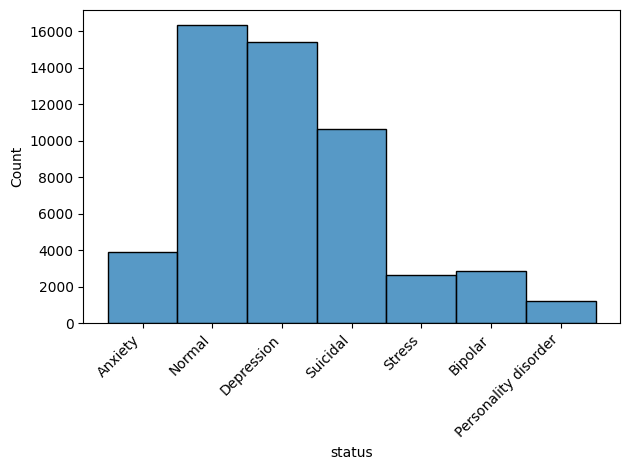

In [7]:
sns.histplot(df['status'])
plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels to 45 degrees
plt.tight_layout() 
plt.show()

- give reason why instead of removing the missing value, we replace with empty string

In [8]:
df['statement'] = df['statement'].fillna('')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


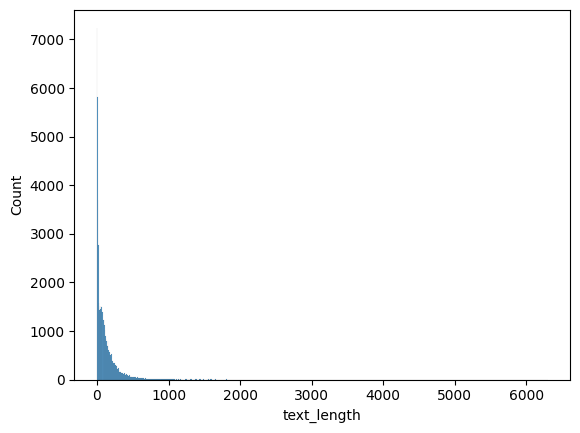

In [9]:
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'])
plt.show()

- give reason why do sampling in here

In [10]:
df['statement'] = df['statement'].str.lower()

In [11]:
df.sample(5)

,statement,status,text_length
6781,procrastinating in sadness will not be able to...,Normal,17
27479,“either be my girlfriend or be out of my life”...,Stress,63
44726,axon those got cancelled now everybody else is...,Normal,17
45361,at degool cafe waiting the clock to be pm,Normal,9
41269,cause of depression 0 mark http t co ha ni dih,Depression,11


In [12]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['statement'] = df['statement'].apply(clean_text)

df.sample(5)

,statement,status,text_length
28047,i also want to set the record straight with my...,Stress,62
11682,does anyone else ever feel this dreadful feeli...,Depression,25
19934,help please i feel so guilty ok,Depression,7
49752,is it normal to still see very brief hallucina...,Bipolar,88
39797,i ve felt this way consistently for probably t...,Depression,27


- removing stop words dan tokenisasi

In [13]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [14]:
stop_words = set(stopwords.words('english'))

df['cleaned'] = df['statement'].apply(lambda x: remove_stopwords(x))
df.sample(5)

,statement,status,text_length,cleaned
9295,hey everyone just checking on anyone who is ne...,Suicidal,32,hey everyone checking anyone needing support h...
31365,its not too much only about,Normal,7,much
46251,tardive dyskinesia medication adjustments and ...,Bipolar,563,tardive dyskinesia medication adjustments mani...
14614,i am going to suffocate myself using helium an...,Suicidal,31,going suffocate using helium maybe trash bag f...
25064,i was very very sad and down earlier now i am ...,Suicidal,421,sad earlier happy feel cathartic seeing suicid...


In [15]:
# Assuming your features are in a column named 'text' and labels in 'label'
X = df['cleaned']  # Feature: the text data
y = df['status']  # Label: target classes

# Splitting data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train

52275    make eye contact people really struggle person...
49099    balancing school social life work balance scho...
10636                  weed made motivated happy motivated
23796    cringe past thoughts omg painful want die badl...
48863                                                     
                               ...                        
11284    used confident cheerful person today become aw...
44732       spanx except missed last week lee gone iplayer
38158    tl dr abused mentally physically parent throug...
860                                          sell tutorial
15795    religious believe god herei want cease exist b...
Name: cleaned, Length: 42434, dtype: object

In [17]:
# ---- TF-IDF ----
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [18]:
# ---- Bag of Words (BoW) ----
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

In [19]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels (convert to numeric)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [20]:
# ---- Word2Vec ----
# Tokenize the sentences for Word2Vec
tokenized_train = [word_tokenize(sentence.lower()) for sentence in X_train]
tokenized_test = [word_tokenize(sentence.lower()) for sentence in X_test]

# Train Word2Vec model
w2v_model = Word2Vec(tokenized_train, vector_size=100, window=5, min_count=1, sg=1)

# Convert sentences to Word2Vec by averaging word vectors
X_train_w2v = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv]
                                or [np.zeros(100)], axis=0) for words in tokenized_train])
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv]
                               or [np.zeros(100)], axis=0) for words in tokenized_test])

In [21]:
def compare_models(models, X_train, y_train, X_test, y_test):
    """
    Fungsi untuk melatih beberapa model machine learning, menghitung metrik evaluasi,
    dan menampilkan hasilnya dalam bentuk DataFrame.

    Parameters:
    - models: List of tuples dengan nama model dan objek model.
    - X_train: Data fitur untuk training.
    - y_train: Label untuk training.
    - X_test: Data fitur untuk testing.
    - y_test: Label untuk testing.

    Returns:
    - DataFrame dengan hasil perbandingan model.
    """
    # Prepare a DataFrame to store results
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

    # Iterate through each model with progress tracking
    for name, model in tqdm(models, desc='Training Models', unit='model'):
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Append the results to the DataFrame
        results = pd.concat([results, pd.DataFrame({
            'Model': [name],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1]
        })], ignore_index=True)

        # Print detailed classification report
        print(f"Classification Report for {name}:\n")
        print(classification_report(y_test, y_pred))
        print("=" * 80)

    # Sort and return the results
    return results.sort_values(by='Accuracy', ascending=False)

In [22]:
# List of models to compare
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Naive Bayes", MultinomialNB()), 
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

In [23]:
# Print comparison results
results = compare_models(models, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Menampilkan hasil
print(results)

Training Models:   0%|          | 0/5 [00:00<?, ?model/s]/tmp/ipykernel_30/769629475.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
Training Models:  20%|██        | 1/5 [00:53<03:32, 53.07s/model]/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       779
           1       0.86      0.69      0.77       580
           2       0.71      0.74      0.73      3100
           3       0.83      0.95      0.89      3327
           4       0.89      0.44      0.58       248
           5       0.73      0.45      0.56       557
           6       0.68      0.64      0.66      2018

    accuracy                           0.76     10609
   macro avg       0.79      0.67      0.71     10609
weighted avg       0.76      0.76      0.76     10609

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.93      0.11      0.20       779
           1       1.00      0.01      0.02       580
           2       0.38      0.98      0.55      3100
           3       0.92      0.59      0.72      3327
           4       0.00      0.00      0.00 

Training Models:  60%|██████    | 3/5 [04:29<03:07, 93.98s/model]

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.90      0.56      0.69       779
           1       0.99      0.36      0.53       580
           2       0.56      0.81      0.67      3100
           3       0.79      0.96      0.87      3327
           4       1.00      0.30      0.46       248
           5       0.97      0.23      0.38       557
           6       0.67      0.41      0.51      2018

    accuracy                           0.70     10609
   macro avg       0.84      0.52      0.59     10609
weighted avg       0.74      0.70      0.67     10609



Training Models:  80%|████████  | 4/5 [12:49<03:54, 234.57s/model]

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       779
           1       0.88      0.68      0.77       580
           2       0.70      0.70      0.70      3100
           3       0.76      0.96      0.85      3327
           4       0.80      0.47      0.59       248
           5       0.70      0.41      0.52       557
           6       0.67      0.57      0.62      2018

    accuracy                           0.74     10609
   macro avg       0.76      0.64      0.68     10609
weighted avg       0.73      0.74      0.73     10609



Training Models: 100%|██████████| 5/5 [16:41<00:00, 200.35s/model]

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       779
           1       0.87      0.74      0.80       580
           2       0.74      0.73      0.74      3100
           3       0.83      0.95      0.88      3327
           4       0.89      0.54      0.67       248
           5       0.67      0.54      0.60       557
           6       0.68      0.64      0.66      2018

    accuracy                           0.77     10609
   macro avg       0.79      0.70      0.74     10609
weighted avg       0.77      0.77      0.77     10609

                 Model  Accuracy  Precision    Recall  F1-Score
4              XGBoost  0.771232   0.768565  0.771232  0.766802
0  Logistic Regression  0.764445   0.763384  0.764445  0.758260
3    Gradient Boosting  0.735508   0.733948  0.735508  0.726443
2        Random Forest  0.695164   0.735945  0.695164  0.673292
1          Naive Bayes  0.509379   0.725960  0.

In [24]:
# Print comparison results
results = compare_models(models, X_train_bow, y_train, X_test_bow, y_test)

# Menampilkan hasil
print(results)

Training Models:   0%|          | 0/5 [00:00<?, ?model/s]/tmp/ipykernel_30/769629475.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
Training Models:  20%|██        | 1/5 [01:38<06:34, 98.64s/model]

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       779
           1       0.83      0.72      0.77       580
           2       0.72      0.69      0.71      3100
           3       0.86      0.95      0.90      3327
           4       0.81      0.54      0.65       248
           5       0.66      0.55      0.60       557
           6       0.63      0.63      0.63      2018

    accuracy                           0.76     10609
   macro avg       0.76      0.70      0.72     10609
weighted avg       0.76      0.76      0.76     10609

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       779
           1       0.71      0.66      0.68       580
           2       0.50      0.75      0.60      3100
           3       0.92      0.62      0.74      3327
           4       0.85      0.16      0.27 

Training Models:  60%|██████    | 3/5 [05:51<03:58, 119.15s/model]

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.90      0.54      0.68       779
           1       0.98      0.39      0.56       580
           2       0.56      0.79      0.66      3100
           3       0.78      0.96      0.86      3327
           4       1.00      0.28      0.44       248
           5       0.95      0.23      0.37       557
           6       0.67      0.43      0.52      2018

    accuracy                           0.69     10609
   macro avg       0.84      0.52      0.58     10609
weighted avg       0.73      0.69      0.67     10609



Training Models:  80%|████████  | 4/5 [09:23<02:31, 151.42s/model]

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.77      0.66      0.72       779
           1       0.89      0.69      0.78       580
           2       0.71      0.69      0.70      3100
           3       0.75      0.96      0.84      3327
           4       0.83      0.44      0.57       248
           5       0.71      0.38      0.50       557
           6       0.67      0.57      0.61      2018

    accuracy                           0.73     10609
   macro avg       0.76      0.63      0.67     10609
weighted avg       0.73      0.73      0.72     10609



Training Models: 100%|██████████| 5/5 [10:15<00:00, 123.04s/model]

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       779
           1       0.87      0.75      0.81       580
           2       0.75      0.72      0.73      3100
           3       0.82      0.95      0.88      3327
           4       0.86      0.53      0.65       248
           5       0.70      0.52      0.60       557
           6       0.68      0.63      0.65      2018

    accuracy                           0.77     10609
   macro avg       0.78      0.70      0.73     10609
weighted avg       0.77      0.77      0.76     10609

                 Model  Accuracy  Precision    Recall  F1-Score
4              XGBoost  0.768687   0.765437  0.768687  0.763379
0  Logistic Regression  0.760204   0.756535  0.760204  0.756323
3    Gradient Boosting  0.729381   0.728979  0.729381  0.719135
2        Random Forest  0.692714   0.730808  0.692714  0.671680
1          Naive Bayes  0.640494   0.697235  0.

In [25]:
# List of models to compare
# List of models to compare (including XGBClassifier)
models_w2v = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]
# Print comparison results
results = compare_models(models_w2v, X_train_w2v, y_train, X_test_w2v, y_test)

# Menampilkan hasil
print(results)

Training Models:   0%|          | 0/4 [00:00<?, ?model/s]/tmp/ipykernel_30/769629475.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
Training Models:  25%|██▌       | 1/4 [00:08<00:25,  8.40s/model]

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       779
           1       0.69      0.51      0.59       580
           2       0.59      0.75      0.66      3100
           3       0.76      0.78      0.77      3327
           4       0.48      0.13      0.20       248
           5       0.54      0.25      0.34       557
           6       0.62      0.53      0.57      2018

    accuracy                           0.66     10609
   macro avg       0.63      0.51      0.54     10609
weighted avg       0.66      0.66      0.65     10609



Training Models:  50%|█████     | 2/4 [01:02<01:10, 35.43s/model]

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.80      0.65      0.72       779
           1       0.81      0.56      0.66       580
           2       0.60      0.75      0.67      3100
           3       0.82      0.93      0.87      3327
           4       0.90      0.31      0.47       248
           5       0.80      0.26      0.39       557
           6       0.66      0.55      0.60      2018

    accuracy                           0.72     10609
   macro avg       0.77      0.57      0.63     10609
weighted avg       0.73      0.72      0.70     10609



Training Models:  75%|███████▌  | 3/4 [19:44<08:51, 531.49s/model]

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       779
           1       0.74      0.57      0.64       580
           2       0.62      0.72      0.67      3100
           3       0.85      0.89      0.87      3327
           4       0.50      0.30      0.37       248
           5       0.59      0.34      0.43       557
           6       0.63      0.59      0.61      2018

    accuracy                           0.71     10609
   macro avg       0.67      0.58      0.61     10609
weighted avg       0.71      0.71      0.70     10609



Training Models: 100%|██████████| 4/4 [20:04<00:00, 301.11s/model]

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       779
           1       0.81      0.67      0.73       580
           2       0.67      0.74      0.70      3100
           3       0.87      0.91      0.89      3327
           4       0.71      0.44      0.54       248
           5       0.67      0.49      0.57       557
           6       0.64      0.61      0.62      2018

    accuracy                           0.75     10609
   macro avg       0.74      0.66      0.69     10609
weighted avg       0.74      0.75      0.74     10609

                 Model  Accuracy  Precision    Recall  F1-Score
3              XGBoost  0.745122   0.744421  0.745122  0.741953
1        Random Forest  0.715242   0.725415  0.715242  0.703875
2    Gradient Boosting  0.708361   0.705495  0.708361  0.702167
0  Logistic Regression  0.656707   0.655011  0.656707  0.646227


In [26]:
# Retrieve the mapping of classes to numeric labels
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Display the mapping
print("Class to Numeric Mapping:", class_mapping)

Class to Numeric Mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


- stemming and lematization 

In [27]:
data_path = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df = pd.read_csv(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [28]:
# Function to encode string labels into numeric labels
def encode_labels(labels):
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)
    return numeric_labels, label_encoder

# Modify the dataset preparation to include label encoding
def prepare_dataset(texts, labels, method="lemmatize", vectorizer_type="tfidf", test_size=0.2):
    processed_texts = preprocess_texts(texts, method=method)
    X, vectorizer = vectorize_texts(processed_texts, vectorizer_type=vectorizer_type)
    
    # Encode labels
    numeric_labels, label_encoder = encode_labels(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(X, numeric_labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test, vectorizer, label_encoder

# Vectorization function
def vectorize_texts(texts, vectorizer_type="tfidf"):
    if vectorizer_type == "tfidf":
        vectorizer = TfidfVectorizer()
        return vectorizer.fit_transform(texts), vectorizer
    else:
        raise ValueError("Unsupported vectorizer type. Only 'tfidf' is supported in this function.")

def preprocess_texts(texts, method="lemmatize"):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    processed_texts = []
    
    for text in texts:
        # Convert non-string values to empty string
        if not isinstance(text, str):
            text = ''
        
        text = text.lower()
        words = word_tokenize(text)
        words = [word for word in words if word.isalpha() and word not in stop_words]
        if method == "lemmatize":
            words = [lemmatizer.lemmatize(word) for word in words]
        elif method == "stem":
            words = [stemmer.stem(word) for word in words]
        processed_text = " ".join(words)
        processed_texts.append(processed_text)
    
    return processed_texts


# Adjust the training function
def train_xgb_model(X_train, y_train, X_test, y_test, label_encoder):
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    
    # Decode numeric predictions back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # Print the classification report
    print("Classification Report for XGBoost:")
    print(classification_report(label_encoder.inverse_transform(y_test), y_pred_labels))


In [29]:
# Example usage with your dataset
texts = df['statement'].tolist()  # Assuming 'text' is the column with the text data
labels = df['status'].tolist()  # Assuming 'status' is the target column with labels

In [30]:
# Prepare the dataset (now including label encoding)
X_train, X_test, y_train, y_test, vectorizer, label_encoder = prepare_dataset(texts, labels, method="lemmatize", vectorizer_type="tfidf")

# Train and evaluate the XGBoost model, passing label_encoder as an argument
train_xgb_model(X_train, y_train, X_test, y_test, label_encoder)

Classification Report for XGBoost:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       779
             Bipolar       0.86      0.72      0.78       580
          Depression       0.69      0.72      0.70      3100
              Normal       0.82      0.95      0.88      3327
Personality disorder       0.97      0.45      0.61       248
              Stress       0.75      0.43      0.55       557
            Suicidal       0.66      0.61      0.63      2018

            accuracy                           0.75     10609
           macro avg       0.79      0.66      0.71     10609
        weighted avg       0.75      0.75      0.75     10609



In [31]:
# Prepare the dataset (now including label encoding)
X_train, X_test, y_train, y_test, vectorizer, label_encoder = prepare_dataset(texts, labels, method="stem", vectorizer_type="tfidf")

# Train and evaluate the XGBoost model, passing label_encoder as an argument
train_xgb_model(X_train, y_train, X_test, y_test, label_encoder)

Classification Report for XGBoost:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.78      0.79       779
             Bipolar       0.86      0.71      0.78       580
          Depression       0.70      0.71      0.71      3100
              Normal       0.83      0.95      0.88      3327
Personality disorder       0.91      0.46      0.61       248
              Stress       0.76      0.47      0.58       557
            Suicidal       0.66      0.64      0.65      2018

            accuracy                           0.76     10609
           macro avg       0.79      0.67      0.71     10609
        weighted avg       0.76      0.76      0.75     10609

